In [229]:
# Import các thư viện
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stat
from sklearn.model_selection import KFold

# **Làm sạch dữ liệu**

In [230]:
df = pd.read_csv("./raw_data.csv", encoding="utf-8")
df = df.drop(["Reelgood_Rating","Unnamed: 0"], axis=1)

In [231]:
# Đặc trưng của dataset
print("\nSố lượng đặc trưng là: {0} ".format(len(df.columns)))

# Đặc trưng số học
numeric = df.dtypes[df.dtypes != 'object'].index
data_numeric = df[numeric]
print("\nSố lượng đặc trưng là dữ liệu số học là : {0} \n {1} ".format(len(numeric),numeric))

# Đặc trưng phân loại
category = df.dtypes[df.dtypes == 'object'].index
data_category = df[category]
print("\nSố lượng đặc trưng là dữ liệu phân loại là: {0} \n {1} ".format(len(category),category))


Số lượng đặc trưng là: 13 

Số lượng đặc trưng là dữ liệu số học là : 2 
 Index(['IMDB_Rating', 'Year'], dtype='object') 

Số lượng đặc trưng là dữ liệu phân loại là: 11 
 Index(['Title', 'Genres', 'Tags', 'Country', 'Source', 'Rated', 'Duration',
       'Description', 'Director', 'Employees', 'User_Votes'],
      dtype='object') 


In [232]:
def missing (df):
    missing_number = df.isna().sum().sort_values(ascending=False)
    missing_percent = (df.isna().sum()*100/df.isna().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

In [233]:
missing(df)

,Missing_Number,Missing_Percent
Rated,2599,58.338945
Source,1652,37.081930
Country,1630,36.588103
Director,907,20.359147
Duration,131,2.940516
User_Votes,59,1.324355
Employees,0,0.000000
Description,0,0.000000
Tags,0,0.000000
Year,0,0.000000


In [234]:
df.head()

,Title,IMDB_Rating,Genres,Year,Tags,Country,Source,Rated,Duration,Description,Director,Employees,User_Votes
0,The Lost City,6.2,"['Romance', 'Action & Adventure']",2022,[],America,Epix,13+ (PG-13),PT1H52M,Follows a reclusive romance novelist who was s...,Aaron Nee,"['Adam Nee', 'Sandra Bullock', 'Channing Tatum...","48,599 votes"
1,Chip 'n Dale: Rescue Rangers,7.2,"['Action & Adventure', 'Animation']",2022,[],NaN,Disney+,7+ (PG),PT1H39M,Thirty years after their popular television sh...,NaN,[],"13,451 votes"
2,Uncharted,6.4,"['Drama', 'Action & Adventure']",2022,['Video Games'],America,NaN,13+ (PG-13),PT1H56M,"A young street-smart, Nathan Drake and his wis...",Ruben Fleischer,"['Tom Holland', 'Mark Wahlberg', 'Antonio Band...","118,363 votes"
3,Spider-Man: No Way Home,8.3,"['Comedy', 'Drama']",2021,"['Teen', 'Superhero', 'Supernatural']",America,NaN,13+ (PG-13),PT2H28M,Peter Parker is unmasked and no longer able to...,Jon Watts,"['Tom Holland', 'Zendaya', 'Benedict Cumberbat...","638,869 votes"
4,Top Gun,6.9,"['Romance', 'Action & Adventure']",1986,"['Military', 'Feel-good']",America,Paramount+,13+ (PG-13),PT1H50M,"A heart-pounding combination of action, music ...",Tony Scott,"['Tom Cruise', 'Kelly McGillis', 'Val Kilmer',...","337,760 votes"


In [235]:
# Chuyển đổi user_votes sang số
df["User_Votes"] = df["User_Votes"].astype(str)
df['User_Votes'] = df['User_Votes'].apply(lambda x: int(x.replace(",", "").split(" ")[0].strip()) if 'nan' not in x else 0)

In [236]:
# Chuyển đổi duration sang số
df["Duration"] = df["Duration"].astype(str)
def convert_to_minutes(str_duration): 
    if str_duration != 'nan':
        str_duration = str_duration[2:].replace("M", "")
        if "H" in str_duration:
            arr_time = str_duration.split("H")
            return int(arr_time[0]) * 60 + int(arr_time[1])
        else:
            return int(str_duration)
    else: return 0
df['Duration'] = df['Duration'].apply(lambda x: convert_to_minutes(x))

In [237]:
# Xử lý biến trống Country
# Nhóm các quốc gia chiếm tỉ lệ thấp nhất -> Other Country
# Giữ lại 5 quốc gia chiếm tỉ lệ cao (America, United Kingdom, Canada, India, France)
for i in range(len(df['Country'])):
	if df.iloc[i,5] != 'America' and df.iloc[i,5] != 'United Kingdom' and df.iloc[i,5] != 'Canada' and df.iloc[i,5] != 'India' and df.iloc[i,5] != 'France':
		df.iloc[i,5] = 'Other Country'
	else:
		df.iloc[i,5] = df.iloc[i,5]
df['Country'].fillna('Other Country', inplace=True) # fillna 
print(df['Country'].unique())

['America' 'Other Country' 'United Kingdom' 'Canada' 'France' 'India']


In [238]:
def bar_plot_data(df: dict, field: str, subtitle: str, figsize=(15, 8), top_filter=15):
    fig, ax1 = plt.subplots(figsize=figsize, dpi=100)
    
    for spline in ['top', 'right', 'left']:
        ax1.spines[spline].set_visible(False)
          
    df_filter = df[field].value_counts().rename_axis(field).reset_index(name='counts')
    if top_filter:
        df_filter = df_filter.head(top_filter)
    sns.barplot(data=df_filter, palette='cool', x='counts', y=field)
    ax1.tick_params(axis='both', which='both', labelsize=12, bottom=True, left=False)
    ax1.set_xlabel(f'count', fontsize=13, color = '#333F4B')
    ax1.set_ylabel(f'{field}', fontsize=13, color = '#333F4B')

    plt.plot(color="white", lw=3)
    fig.suptitle(subtitle, fontsize=18)
    plt.show()

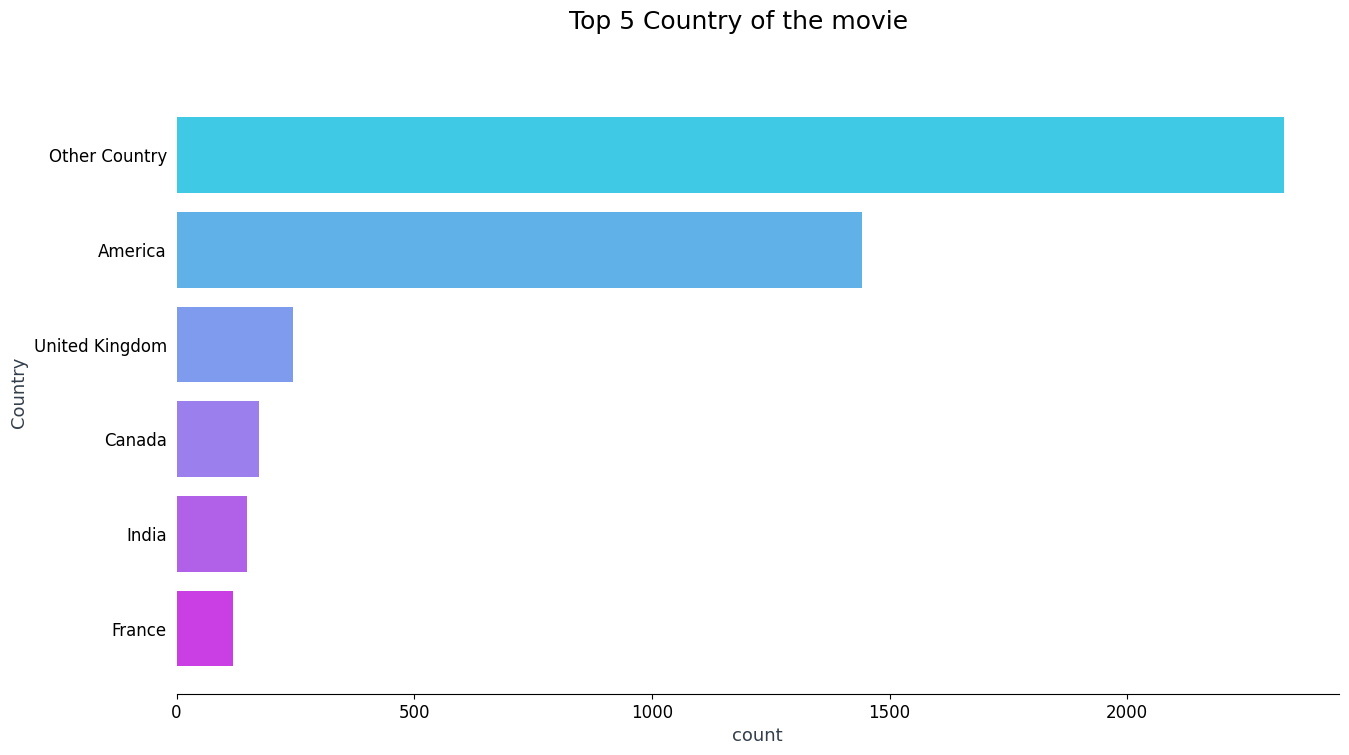

In [239]:
bar_plot_data(df, "Country", "Top 5 Country of the movie")

	Nhận xét : 
- Sau khi rút gọn còn lại 5 quốc gia phổ biến nhất thì lượng phim của nước Mỹ (America) vẫn chiếm tỷ lệ cao nhất , thấp nhất là Pháp(France).
- Điều này cho thấy Mỹ là quốc gia có nền điện ảnh lớn nhất toàn cầu.

In [240]:
# Xử lý biến trống Source
# Giữ lại Source phim của top 5 quốc gia đã được chọn
for i in range(len(df['Source'])):
	if df.iloc[i,5] != 'America' and df.iloc[i,5] != 'United Kingdom' and df.iloc[i,5] != 'Canada' and df.iloc[i,5] != 'India' and df.iloc[i,5] != 'France':
		df.iloc[i,6] = 'Other Source'
	else:
		df.iloc[i,6] = df.iloc[i,6]
df['Source'].fillna('Other Source', inplace=True) # fillna

In [241]:
# Xử lý biến trống Rated
for i in range(len(df['Rated'])):
	if df.iloc[i,7] == '18+ (R)':
		df.iloc[i,7] = 'Adults'
	if df.iloc[i,7] == '16+' or df.iloc[i,7] == '13+ (PG-13)':
		df.iloc[i,7] = 'Young Adults'
	if df.iloc[i,7] == '7+ (PG)':
		df.iloc[i,7] = 'Kids'
	if df.iloc[i,7] == 'All (G)':
		df.iloc[i,7] = 'General'
df['Rated'].fillna('General', inplace=True) #fillna
print(df['Rated'].unique())

['Young Adults' 'Kids' 'Adults' 'General']


<AxesSubplot:xlabel='Country', ylabel='Rated'>

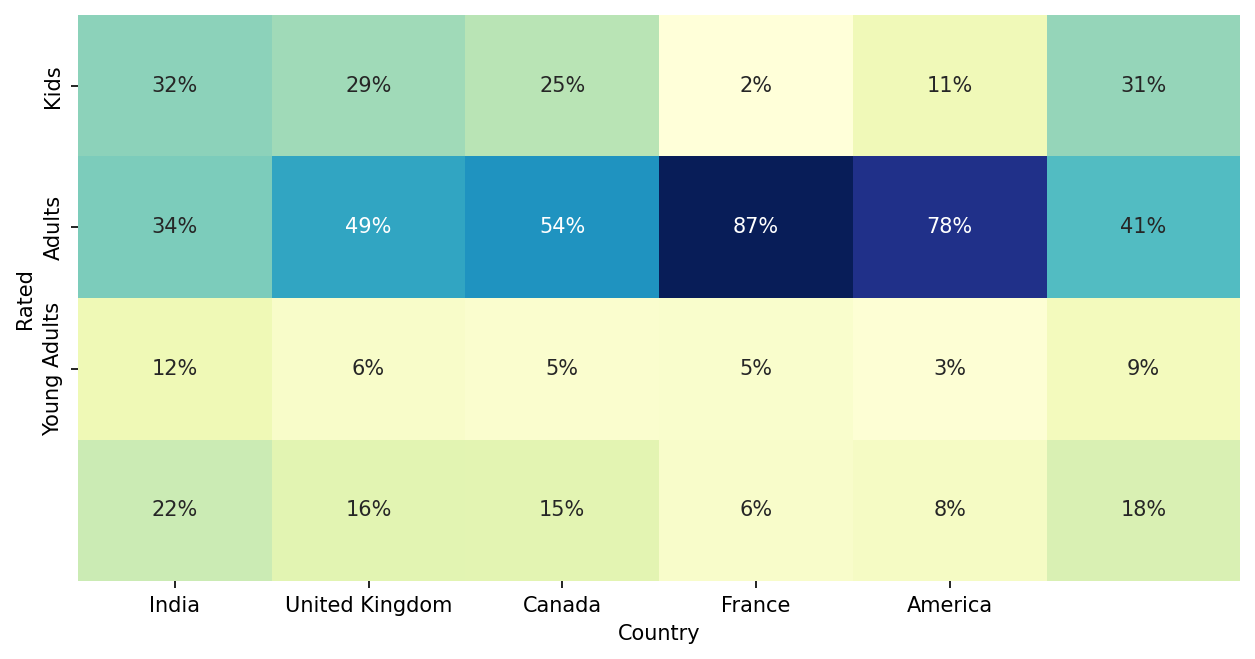

In [242]:
dataframe = pd.DataFrame(df, columns=['Country', 'Rated'])
dataframe = dataframe.groupby('Country')['Rated'].sum().sort_values(ascending=False).reset_index()[:10]
data =  dataframe['Country']
df_heatmap = df.loc[df['Country'].isin(data)]
df_heatmap = pd.crosstab(df_heatmap['Country'], df_heatmap['Rated'] , normalize='index').T
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)

country_list = ['India', 'United Kingdom', 'Canada', 'France', 'America']
rate_list = ['Kids', 'Adults', 'Young Adults']
sns.heatmap(df_heatmap, annot=True, fmt='1.0%', cmap='YlGnBu', cbar=False, xticklabels=country_list, yticklabels=rate_list)

	Nhận xét:
- Độ tuổi xem phim nhiều nhất rơi vào độ tuổi thanh niên , trên 18 tuổi (Adults) . Chiếm tỉ lệ cao nhất là nước Mỹ (quốc gia sản xuất phim nhiều nhất thế giới) . Thấp nhất là Ấn Độ.
- Độ tuổi trẻ em chiếm lượt xem nhiều đứng thứ hai.
- Cuối cùng tuổi vị thành nên (Young Adults) là độ tuổi chiếm lượt xem ít nhất.

=> Các nhân tố trên cho thấy rằng , việc đánh giá phim hay hoặc không hay , phổ biến hay không thì độ tuổi cũng là yếu tố có sự ảnh hưởng.

In [243]:
# Xử lý biến trống Director
for i in range(len(df['Director'])):
	if df.iloc[i,5] != 'America' and df.iloc[i,5] != 'United Kingdom' and df.iloc[i,5] != 'Canada' and df.iloc[i,5] != 'India' and df.iloc[i,5] != 'France':
		df.iloc[i,10] = 'Other Director'
	else:
		df.iloc[i,10] = df.iloc[i,10]
df['Director'].fillna('Other Director', inplace=True) #fillna

In [244]:
# Kết quả sau khi fill dữ liệu trống
missing(df)

,Missing_Number,Missing_Percent
User_Votes,0,0.0
Employees,0,0.0
Director,0,0.0
Description,0,0.0
Duration,0,0.0
Rated,0,0.0
Source,0,0.0
Country,0,0.0
Tags,0,0.0
Year,0,0.0


In [245]:
df.to_csv('clean_data.csv')

In [246]:
# Label encoding
lb = LabelEncoder()
list_feature =['Country', 'Source', 'Rated']
print("Trước khi chuyển đổi:\n{0}".format(df['Rated'].head()))
for item in list_feature:
    lbe = LabelEncoder() 
    ds = df[item].values.tolist()
    lbe.fit(ds) 
    df[item] = lbe.transform(ds)
print("Sau khi chuyển đổi:\n{0}".format(df['Rated'].head()))

Trước khi chuyển đổi:
0    Young Adults
1            Kids
2    Young Adults
3    Young Adults
4    Young Adults
Name: Rated, dtype: object
Sau khi chuyển đổi:
0    3
1    2
2    3
3    3
4    3
Name: Rated, dtype: int32


In [247]:
# Phân tách cột có kiểu object

mlb = MultiLabelBinarizer()

df["Genres"] = df["Genres"].apply(lambda x: x.replace("'", "") if "'" in x else x)
df["Tags"] = df["Tags"].apply(lambda x: x.replace("'", "") if "'" in x else x)
df["Employees"] = df["Employees"].apply(lambda x: x.replace("'", "") if "'" in x else x)

df["Genres"] = df["Genres"].apply(lambda x: x.replace("[", "") if "[" in x else x)
df["Tags"] = df["Tags"].apply(lambda x: x.replace("[", "") if "[" in x else x)
df["Employees"] = df["Employees"].apply(lambda x: x.replace("[", "") if "[" in x else x)

df["Genres"] = df["Genres"].apply(lambda x: x.replace("]", "") if "]" in x else x)
df["Tags"] = df["Tags"].apply(lambda x: x.replace("]", "") if "]" in x else x)
df["Employees"] = df["Employees"].apply(lambda x: x.replace("]", "") if "]" in x else x)

df["Genres"] = df["Genres"].apply(lambda x: x + 'empty' if not x else x)
df["Tags"] = df["Tags"].apply(lambda x: x + 'empty' if not x else x)
df["Employees"] = df["Employees"].apply(lambda x: x + 'empty' if not x else x)

# Phân tách genres
df = df.join(
            pd.DataFrame(
                mlb.fit_transform(df['Genres'].str.split(', ')),
                index=df.index,
                columns="Genre_" + mlb.classes_))
# Phân tách tag 
df = df.join(
            pd.DataFrame(
                mlb.fit_transform(df.pop('Tags').str.split(', ')),
                index=df.index,
                columns="Tag_" + mlb.classes_))

In [248]:
df.head()

,Title,IMDB_Rating,Genres,Year,Country,Source,Rated,Duration,Description,Director,...,Tag_Time Travel,Tag_Toy,Tag_Twins,Tag_Vampire,Tag_Video Games,Tag_War,Tag_World War II,Tag_Wrestling,Tag_Zombie,Tag_empty
0,The Lost City,6.2,"Romance, Action & Adventure",2022,0,5,3,112,Follows a reclusive romance novelist who was s...,Aaron Nee,...,0,0,0,0,0,0,0,0,0,1
1,Chip 'n Dale: Rescue Rangers,7.2,"Action & Adventure, Animation",2022,4,20,2,99,Thirty years after their popular television sh...,Other Director,...,0,0,0,0,0,0,0,0,0,1
2,Uncharted,6.4,"Drama, Action & Adventure",2022,0,20,3,116,"A young street-smart, Nathan Drake and his wis...",Ruben Fleischer,...,0,0,0,0,1,0,0,0,0,0
3,Spider-Man: No Way Home,8.3,"Comedy, Drama",2021,0,20,3,148,Peter Parker is unmasked and no longer able to...,Jon Watts,...,0,0,0,0,0,0,0,0,0,0
4,Top Gun,6.9,"Romance, Action & Adventure",1986,0,21,3,110,"A heart-pounding combination of action, music ...",Tony Scott,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

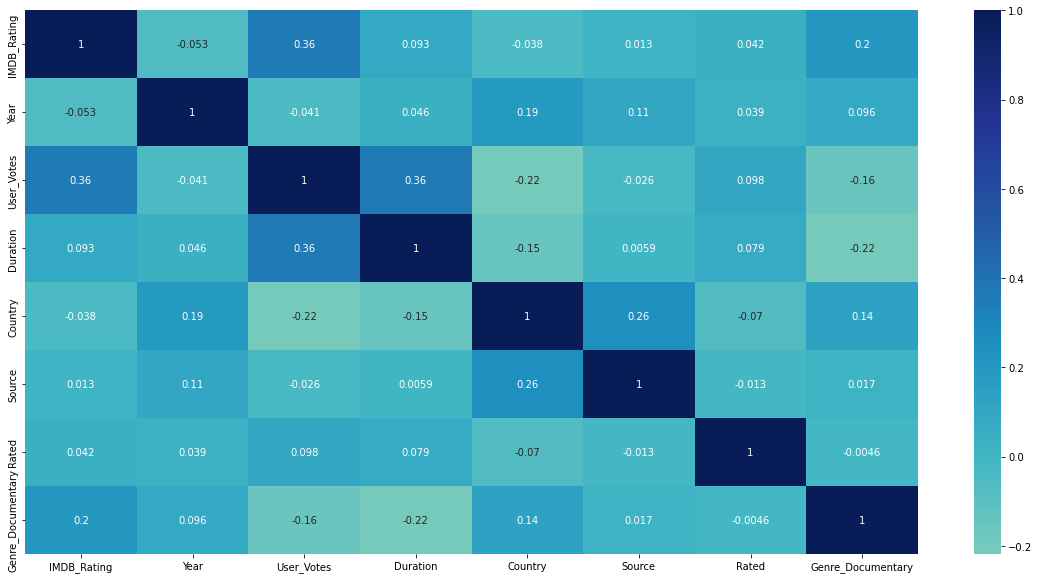

In [249]:
fig, ax = plt.subplots(figsize = (20,10))
data_heatmap = df[['IMDB_Rating', 'Year', 'User_Votes', 'Duration','Country','Source','Rated','Genre_Documentary']].corr()
# data_heatmap = df.drop(['Genres', 'Title', 'Description', 'Director','Employees'], axis=1).corr()
sns.heatmap(data_heatmap,center=0, annot=True,cmap='YlGnBu')

	Nhận xét: 
- Sau khi làm sạch dữ liệu thì tương quan giữa các đặc trưng với IMDB_Rating vẫn khá thấp.
- User_Votes và Genre_Documentary có độ tương quan tốt nhất với IMDB_Rating.

In [250]:
k = 5
cols = data_heatmap.nlargest(k, 'IMDB_Rating')['IMDB_Rating'].index
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Đặc trưng có mối tương quan cao']
most_corr

,Đặc trưng có mối tương quan cao
0,IMDB_Rating
1,User_Votes
2,Genre_Documentary
3,Duration
4,Rated


In [251]:
def plot_data(df,feature):
	plt.figure(figsize=(10,6))
	plt.subplot(1,2,1)
	df[feature].hist() # histogram
	plt.subplot(1,2,2)
	stat.probplot(df[feature],dist='norm',plot=plt)# prob plot
	plt.show()

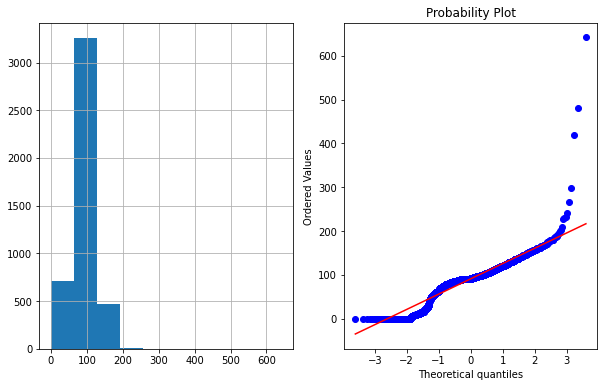

In [252]:
plot_data(df,'Duration')

	Duration phân bố chuẩn

In [253]:
# Đặc trưng IMDB_Rating được dùng để dự đoán
df['IMDB_Rating'].describe()

count    4455.000000
mean        6.326487
std         1.347395
min         1.200000
25%         5.500000
50%         6.500000
75%         7.300000
max        10.000000
Name: IMDB_Rating, dtype: float64

<AxesSubplot:xlabel='IMDB_Rating', ylabel='Count'>

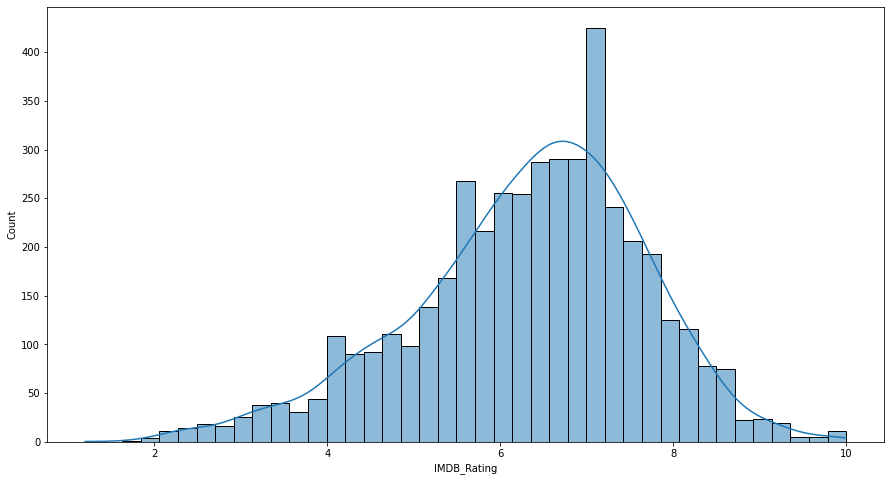

In [254]:
# Đặc trưng dùng để dự đoán
fig, ax = plt.subplots(figsize = (15,8))
sns.histplot(df['IMDB_Rating'],kde=True)

In [255]:
X = df.drop(['Genres','Title','Description','Director','Employees','IMDB_Rating'] , axis = 1)
y = df['IMDB_Rating'] # Target variable

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 70% training và 30% test

In [257]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')
y_train.to_csv('y_train.csv')